# Histogram Equalization

As final models the following 3 algorithms were chosen:
* FaceNet512
* ArcFace
* VGG-Face

In [6]:
%cd /tf/notebooks

/tf/notebooks


In [7]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [8]:
import itertools
from itertools import permutations
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
from PIL import Image
from sklearn.metrics import roc_auc_score, accuracy_score
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as st
import tensorflow as tf

from utils import (
    calculate_confidence_interval, calculate_performance_per_threshold,
    count_distances,plot_performance_per_threshold,
    get_metric_comparision, plot_score_distribution,
    perform_significance_test, calculate_distribution_difference,plot_face_heatmap
)
from preprocessing import equalize_image


import cv2
from deepface import DeepFace


In [9]:
def load_image(shape,path,preprocessing = None):
    if preprocessing is not None:
        img = preprocessing(path)
        img = resize(img,shape)
    else:
        img = Image.open(path).resize(shape)
        img = np.array(img)
    return img

## Example

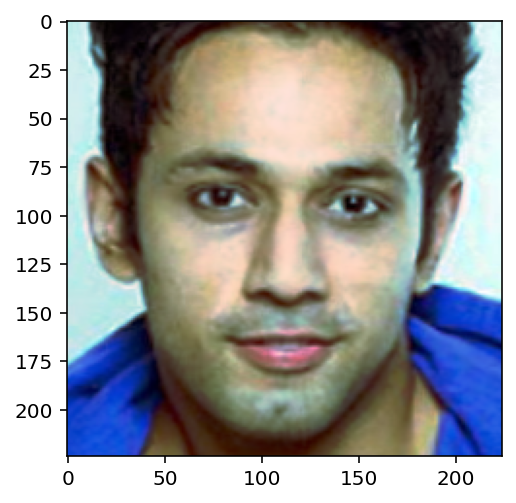

In [11]:
indian_img_path = 'data/race_per_7000/Indian/m.0l8nmsx/000016_00@hi.jpg'
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = equalize_image)
plt.imshow(indian_img);

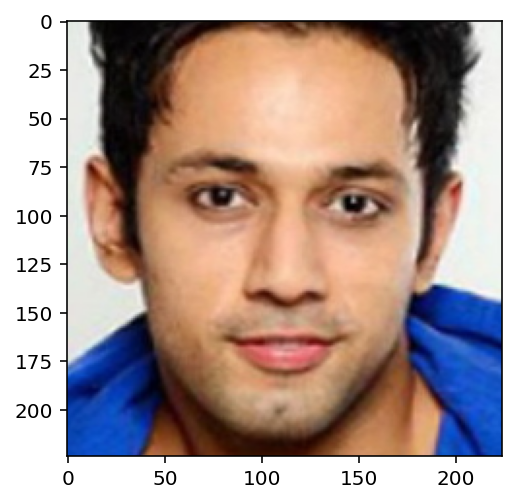

In [12]:
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = None)
plt.imshow(indian_img);

# Evaluation

## Performance comparison

Due to the balanced target labels (50% pairs and 50% non-pairs) we chose to use Accuracz and AUROC as evaluation metrics.

### Facenet512

In [13]:
facenet_model = "facenet_histogram_equalization"

In [14]:
facenet_summary = get_metric_comparision(facenet_model, roc_auc_score)

facenet_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.943805,0.942859,0.944750
0,Asian,0.937317,0.936462,0.938172
0,Caucasian,0.901409,0.900222,0.902596
0,African,0.897103,0.895949,0.898256


In [15]:
facenet_summary = get_metric_comparision(facenet_model, accuracy_score)

facenet_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.885787,0.884574,0.886999
0,Asian,0.867497,0.866234,0.868759
0,African,0.829460,0.828179,0.830741
0,Caucasian,0.775860,0.774327,0.777393


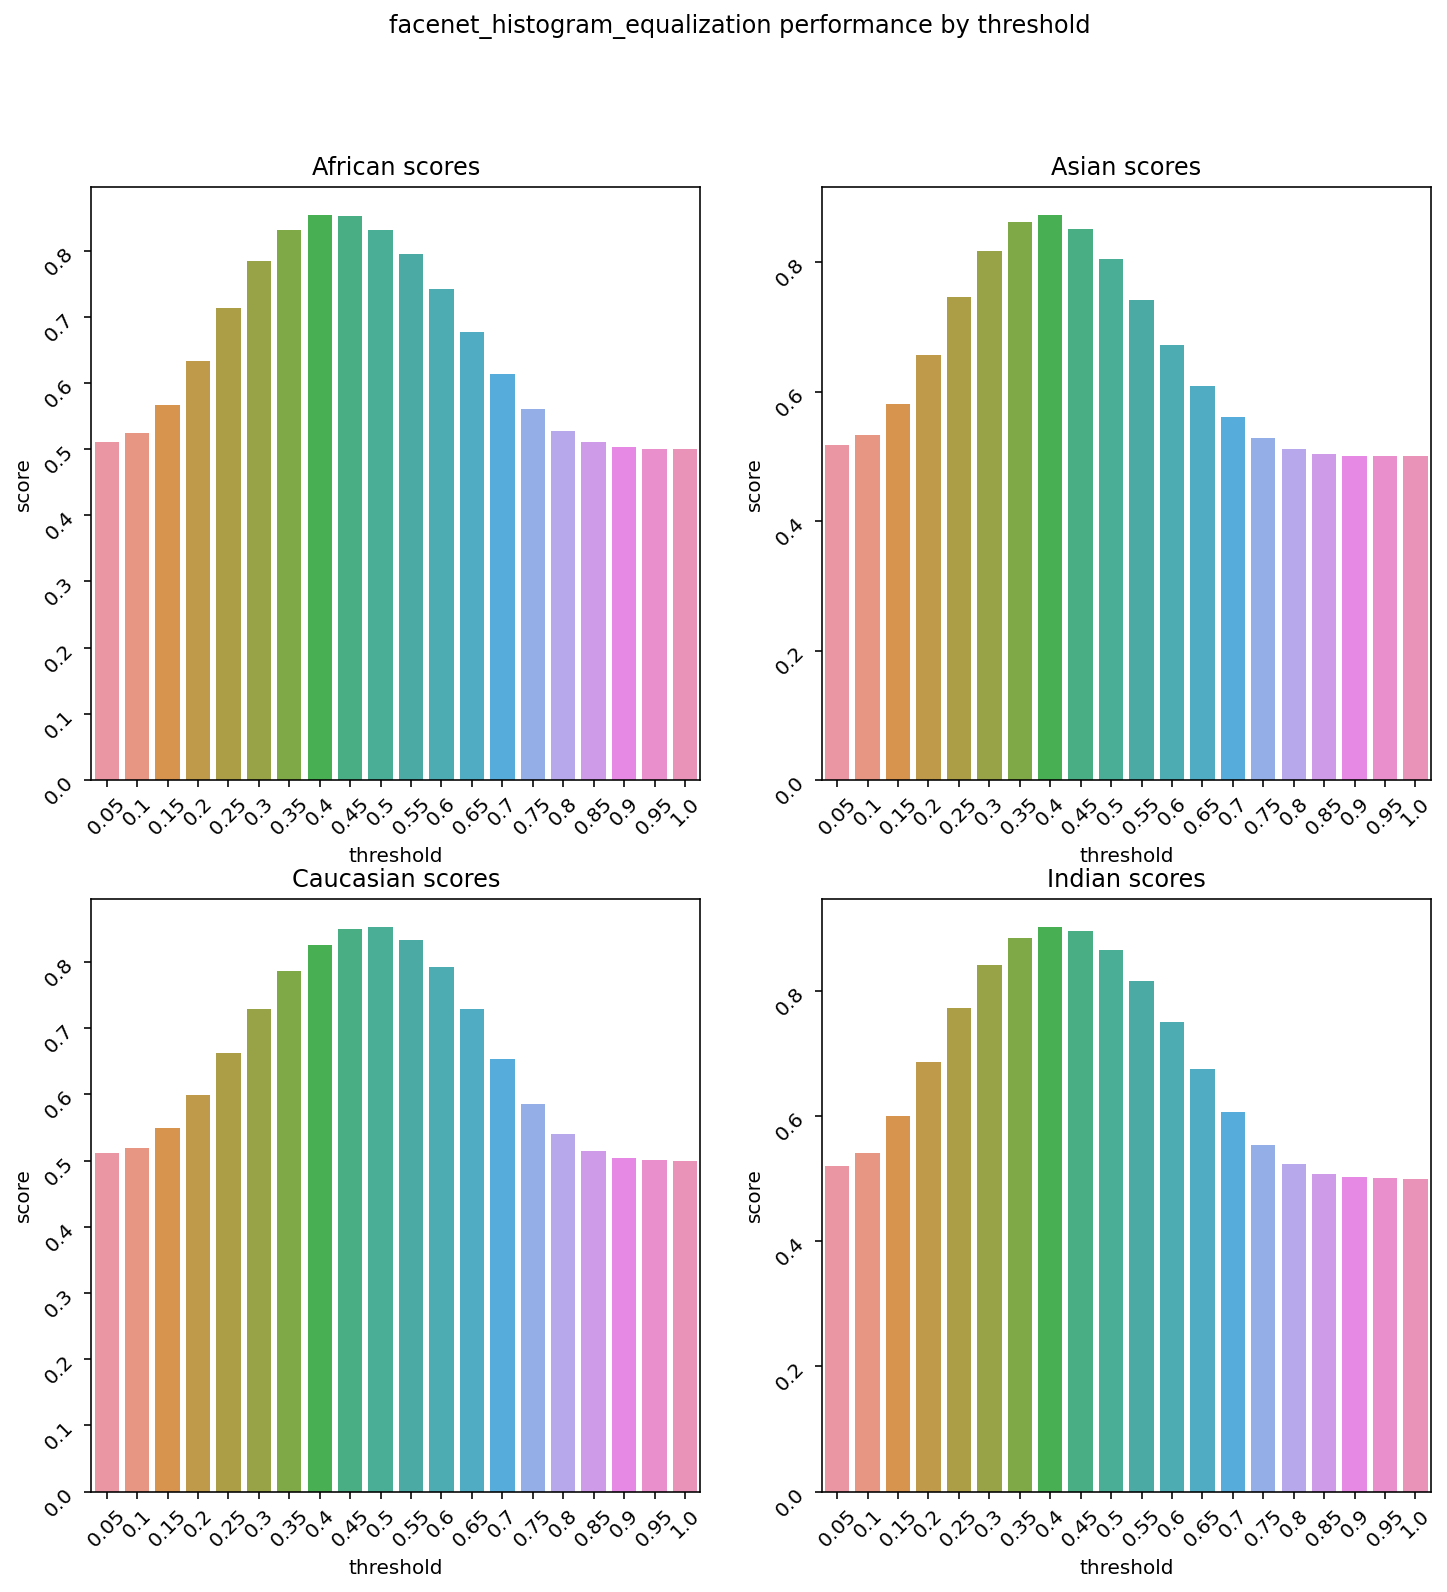

In [16]:
plot_performance_per_threshold(facenet_model)

**Result**:
* Significant performance drop from Indian to Asian (appx. 10% AUROC and accuracy)
* Interestingly Indian lower CI is higher than higher CI of Caucasians
* CI of Asians is also wider
* Best performing thresholds differ. Especially Asian which tells us that one threshold might not make sense

### VGG-Face

In [17]:
vgg_face_model = "vgg_face_histogram_equalization"

In [18]:
vgg_summary = get_metric_comparision(vgg_face_model, roc_auc_score)

vgg_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.900860,0.899726,0.901995
0,Asian,0.882475,0.881230,0.883719
0,Caucasian,0.825436,0.823912,0.826960
0,African,0.817074,0.815447,0.818700


In [19]:
vgg_summary = get_metric_comparision(vgg_face_model, accuracy_score)

vgg_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.776407,0.774907,0.777907
0,Caucasian,0.755323,0.753778,0.756869
0,African,0.718080,0.716437,0.719723
0,Asian,0.717763,0.716188,0.719339


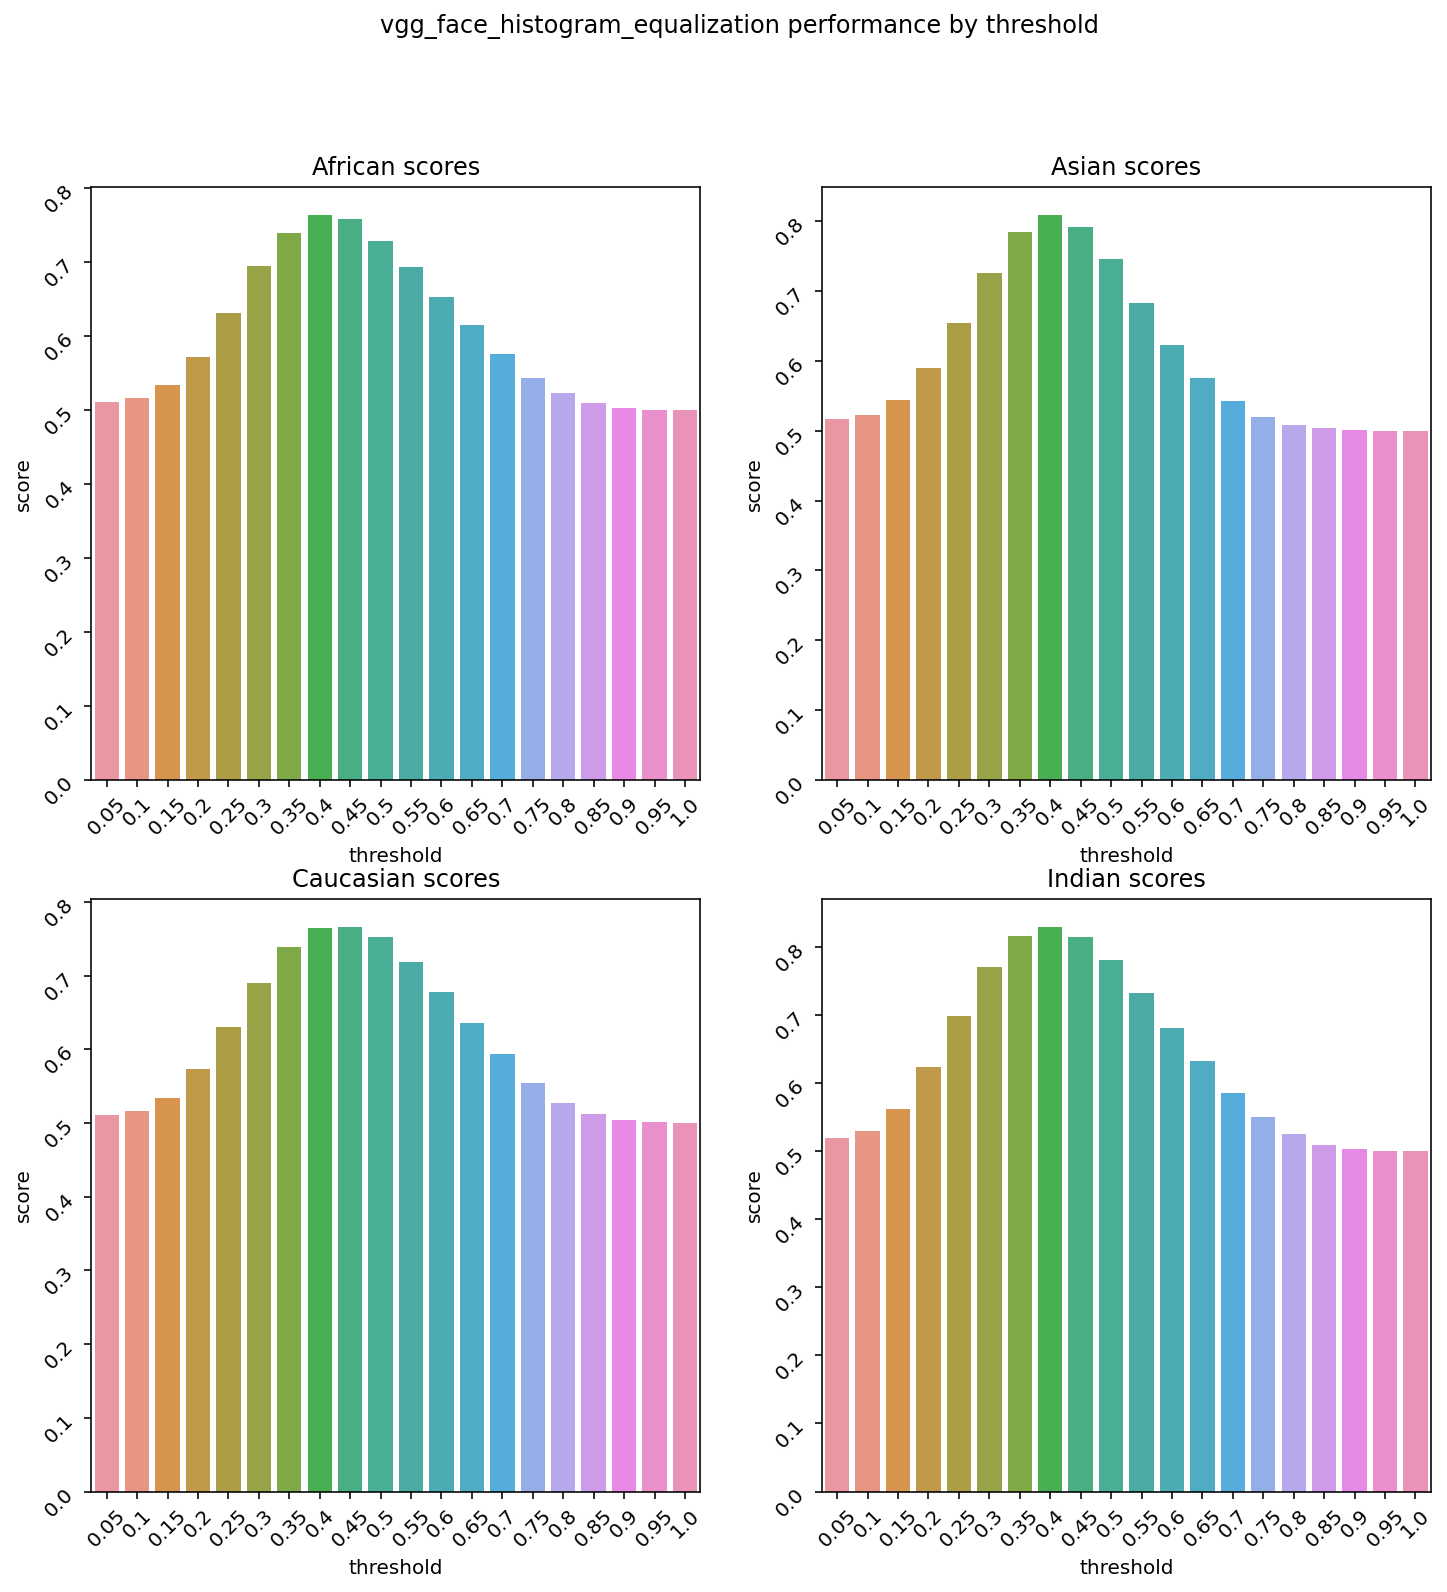

In [20]:
plot_performance_per_threshold(vgg_face_model)

**Result**:
* Overall performance is worse than with FaceNet512
* Mean performance is though only 6% difference between highest and lowest, indicating more fairness
* Varying performance for Asians again
* Partly overlapping CIs
* Thresholds are more fair which is reflected in the fair performance

### ArcFace

In [21]:
arcface_model = "arcface_histogram_equalization"

In [22]:
arcface_summary = get_metric_comparision(arcface_model, roc_auc_score)

arcface_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.850920,0.849506,0.852335
0,Asian,0.828955,0.827419,0.830491
0,Caucasian,0.807221,0.805528,0.808913
0,African,0.805947,0.804372,0.807523


In [23]:
arcface_summary = get_metric_comparision(arcface_model, accuracy_score)

arcface_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.652383,0.650715,0.654052
0,Caucasian,0.642470,0.640690,0.644250
0,African,0.631560,0.629849,0.633271
0,Asian,0.623440,0.621641,0.625239


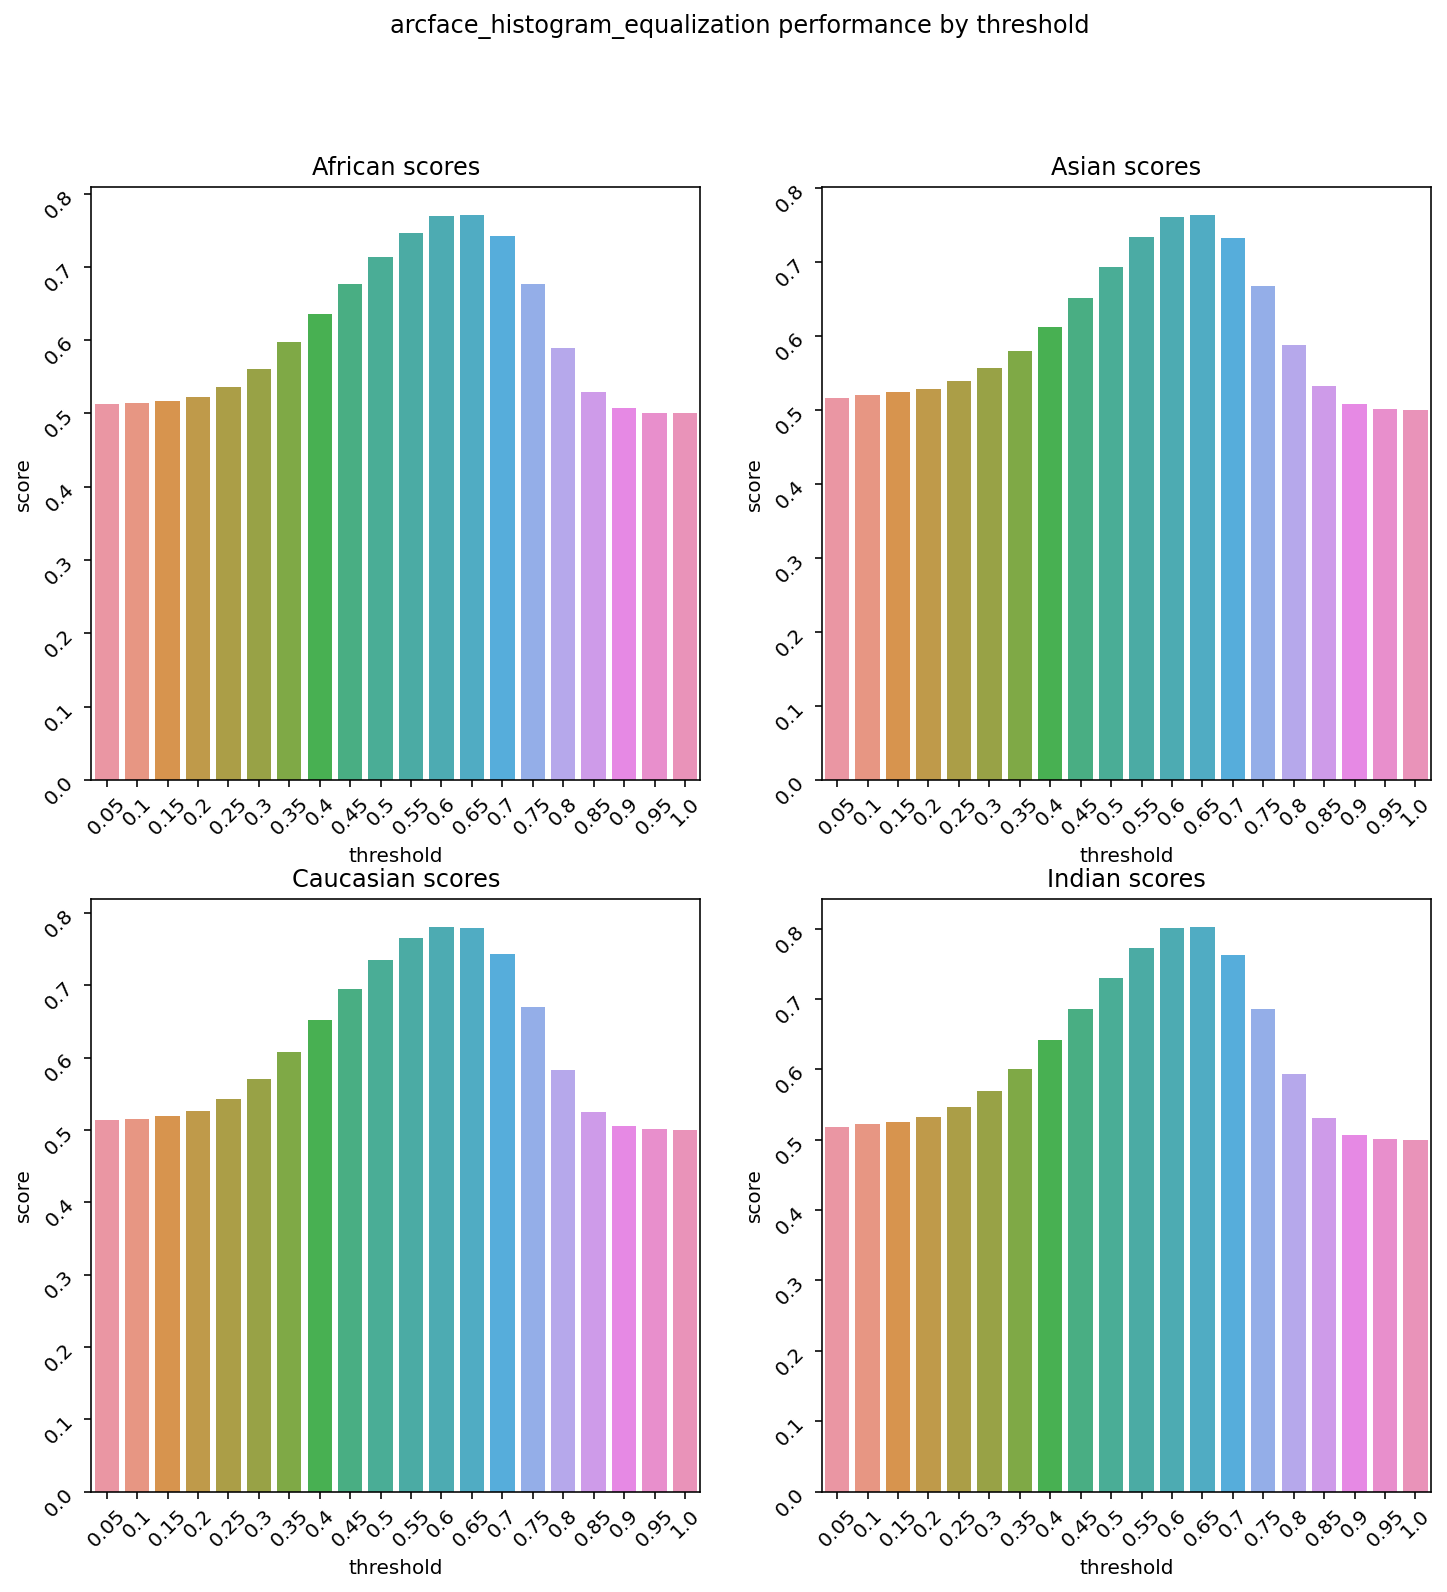

In [24]:
plot_performance_per_threshold(arcface_model)

**Result**:
* Worst overall performance
* Only 5% decrease between best and worst which seems to be fairer
* Asians again wide CI compared to e.g. Caucasian
* Best thresholds is shifted to the right but rather similar

## Distance distribution

This is the distribution of the predicted distance between the pairs. In a first plot they will be generally visualised and then paised on pairs vs. non-pairs.
An ideal model would predict two peaking curves on the outer ends of the plot indicating good discrimination.

### FaceNet512

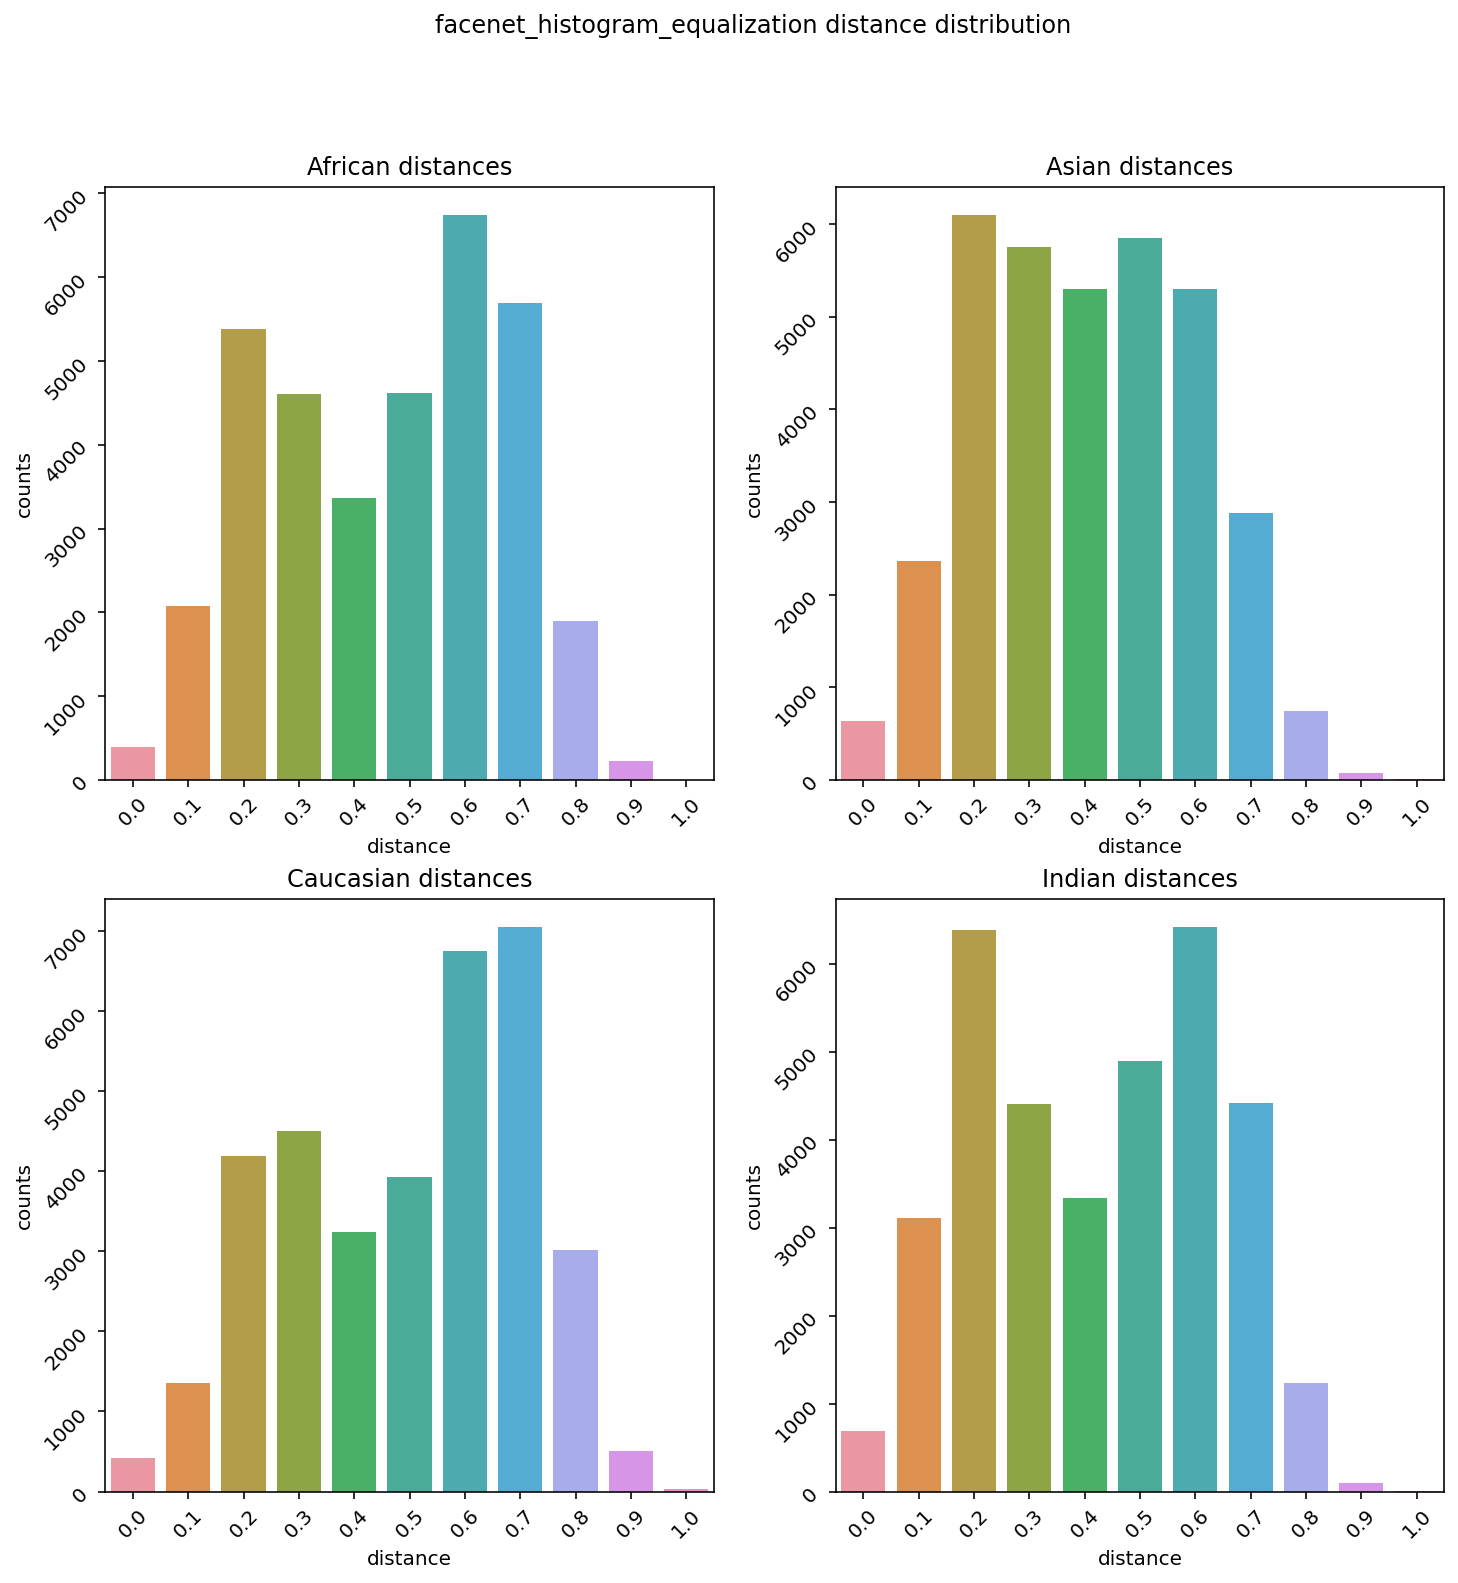

In [25]:
plot_score_distribution(facenet_model)

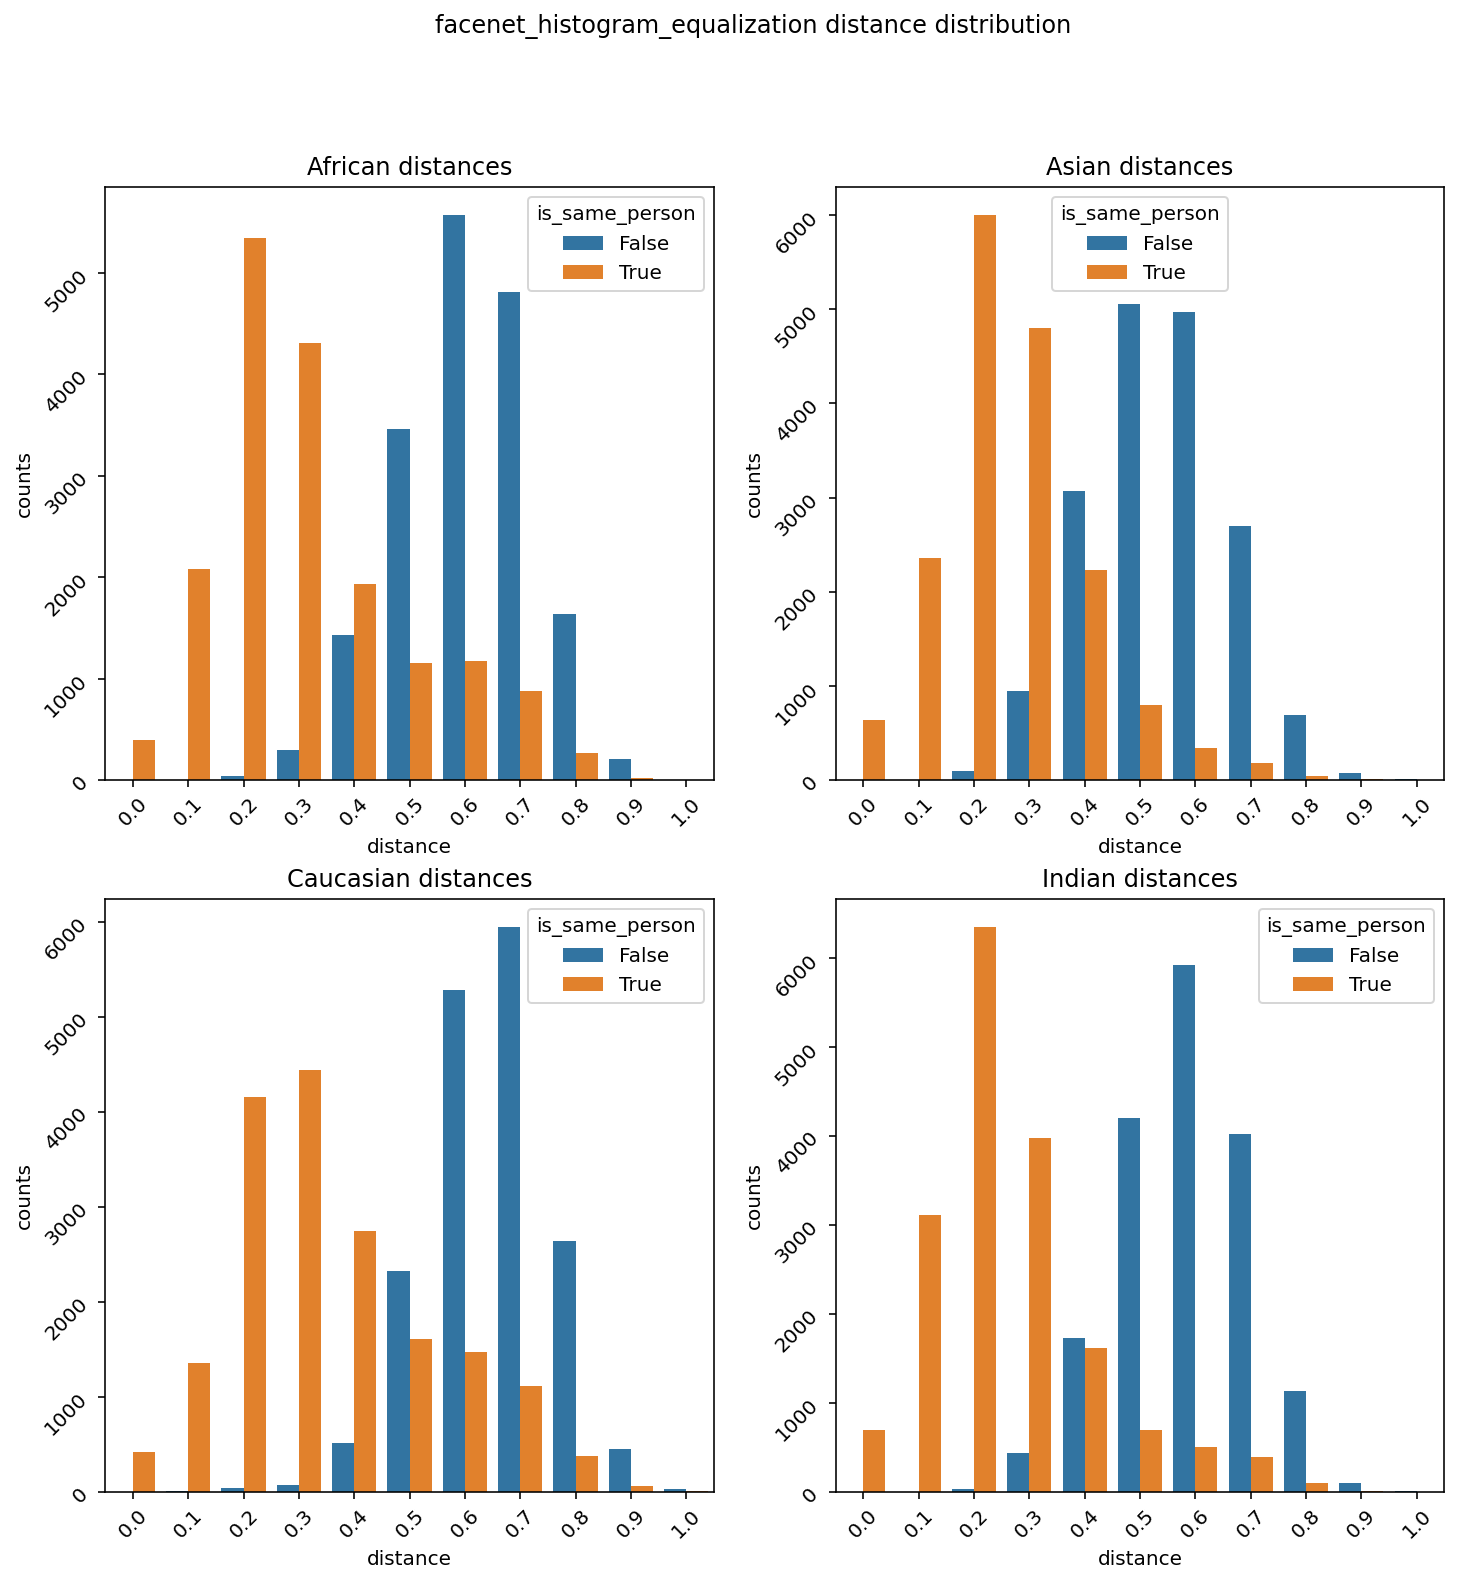

In [26]:
plot_score_distribution(facenet_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [27]:
print("Asian difference in mean:",calculate_distribution_difference(facenet_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(facenet_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(facenet_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(facenet_model,"Indian"))

Asian difference in mean: -0.4022235055057768
African difference in mean: -0.4317872944275673
Caucasian difference in mean: -0.44396716491843213
Indian difference in mean: -0.4869380275068988


**Results**:
* Only the Asian model does not show two spiking parts. This means the distinction is done very badly. For the three other spikes are at least visible.
* All models have heavy overlaps which means there is always a trade off when choosing a threshold.
* Only the asian threshold is shifted to the left.

### VGG-Face


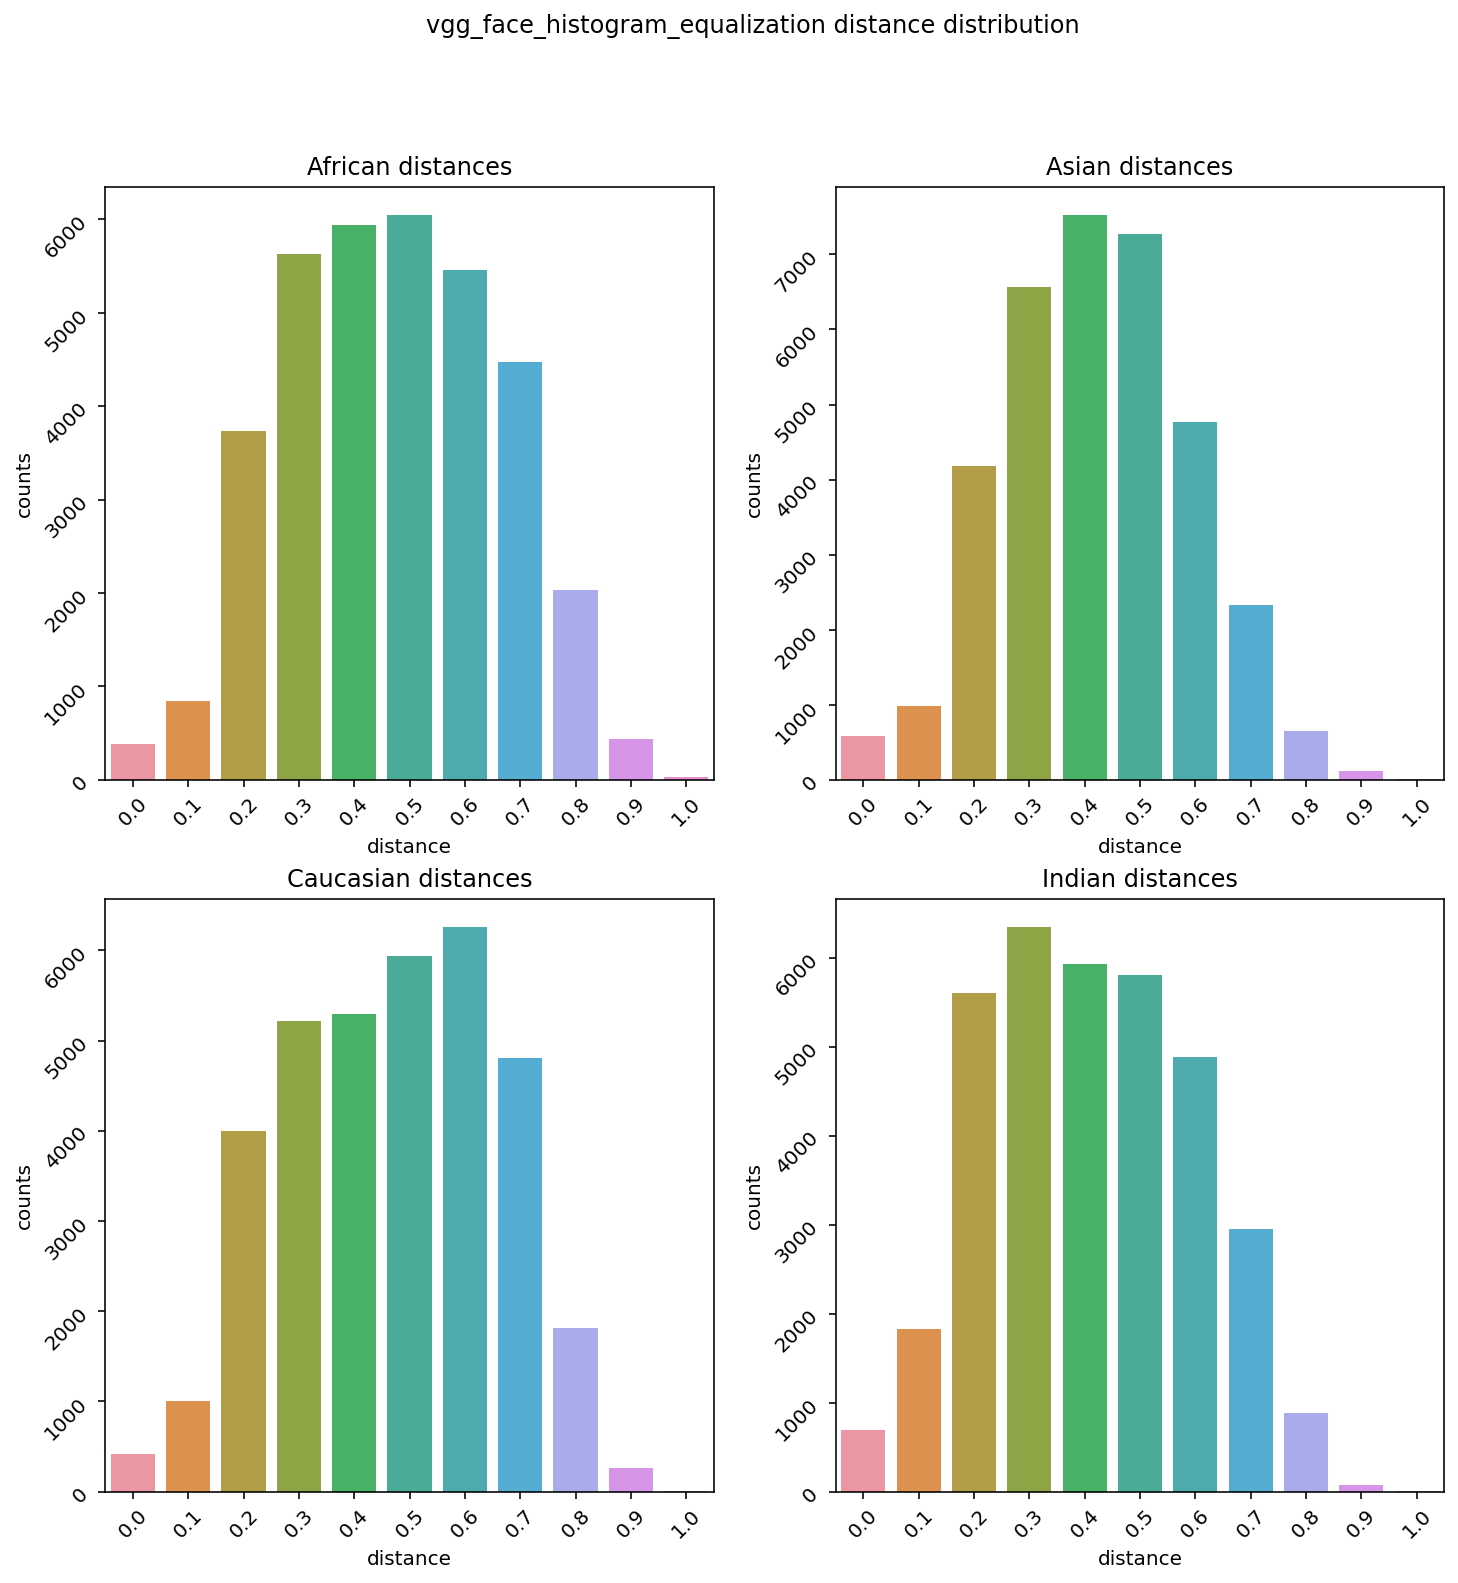

In [28]:
plot_score_distribution(vgg_face_model)

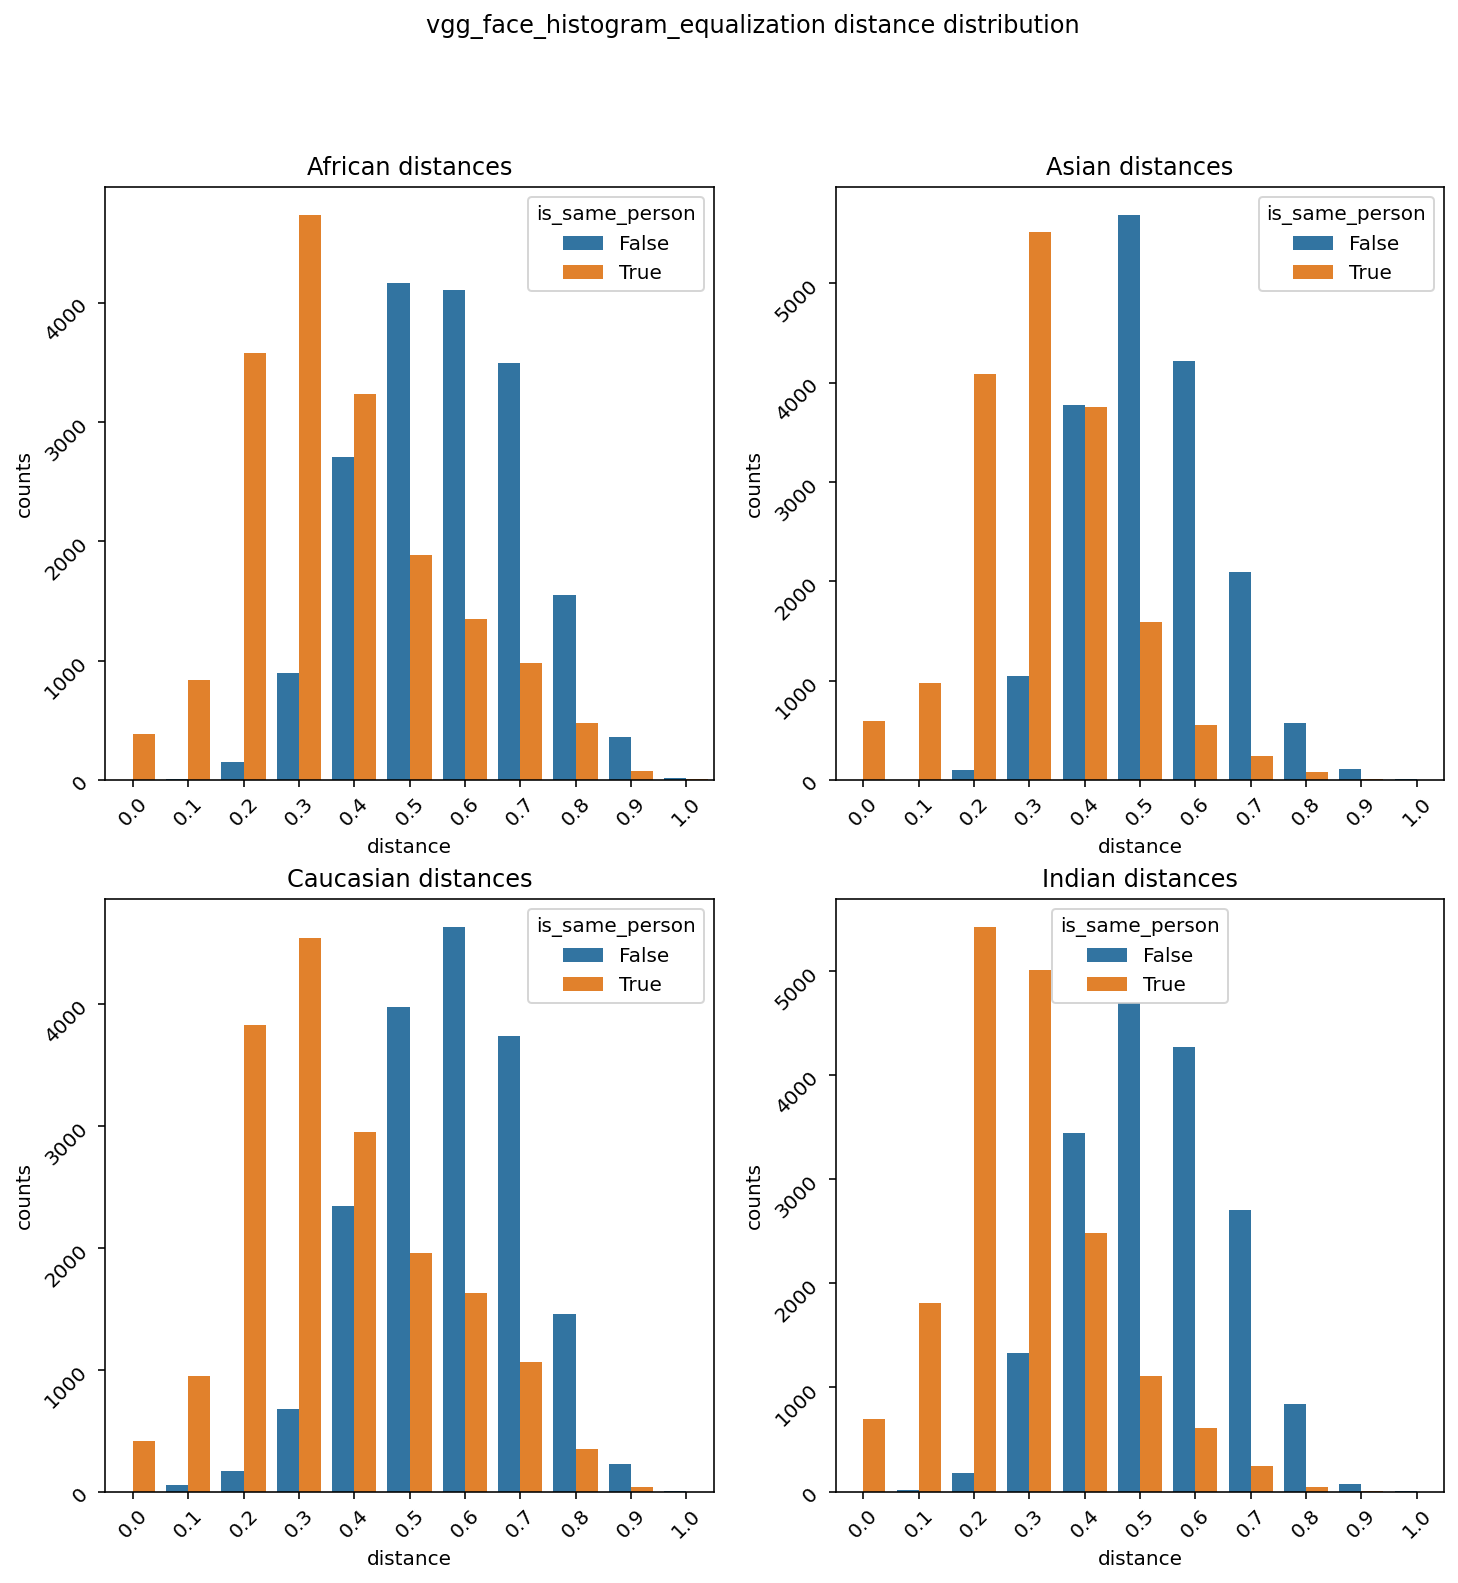

In [29]:
plot_score_distribution(vgg_face_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [30]:
print("Asian difference in mean:",calculate_distribution_difference(vgg_face_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(vgg_face_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(vgg_face_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(vgg_face_model,"Indian"))

Asian difference in mean: -0.20615689488203753
African difference in mean: -0.1997077089578625
Caucasian difference in mean: -0.2222117486417926
Indian difference in mean: -0.2642036854375929


**Results**:
* No spikes in any ethnic group indicating bad discrimination.
* Even heavier overlaps = worse performance

### ArcFace

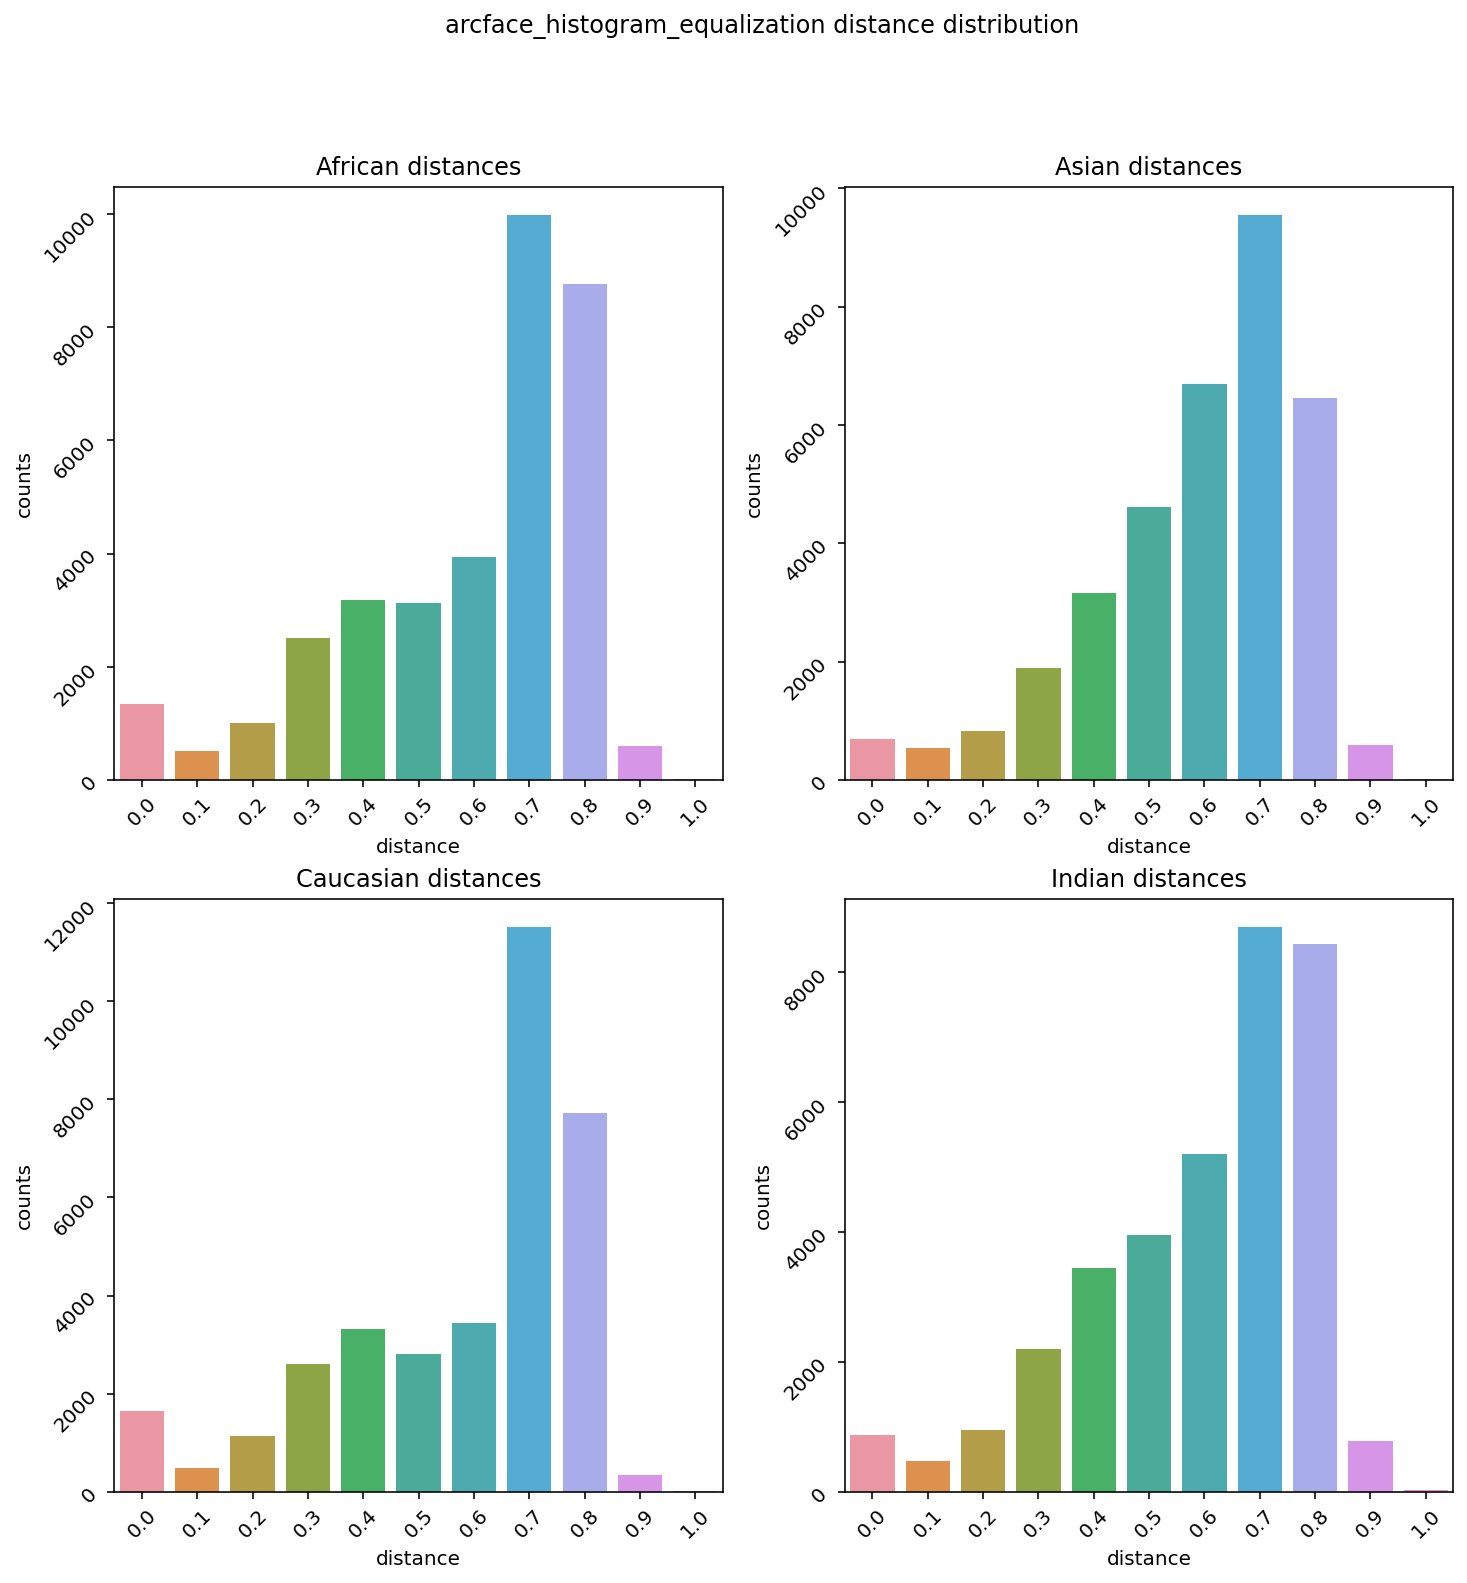

In [31]:
plot_score_distribution(arcface_model)

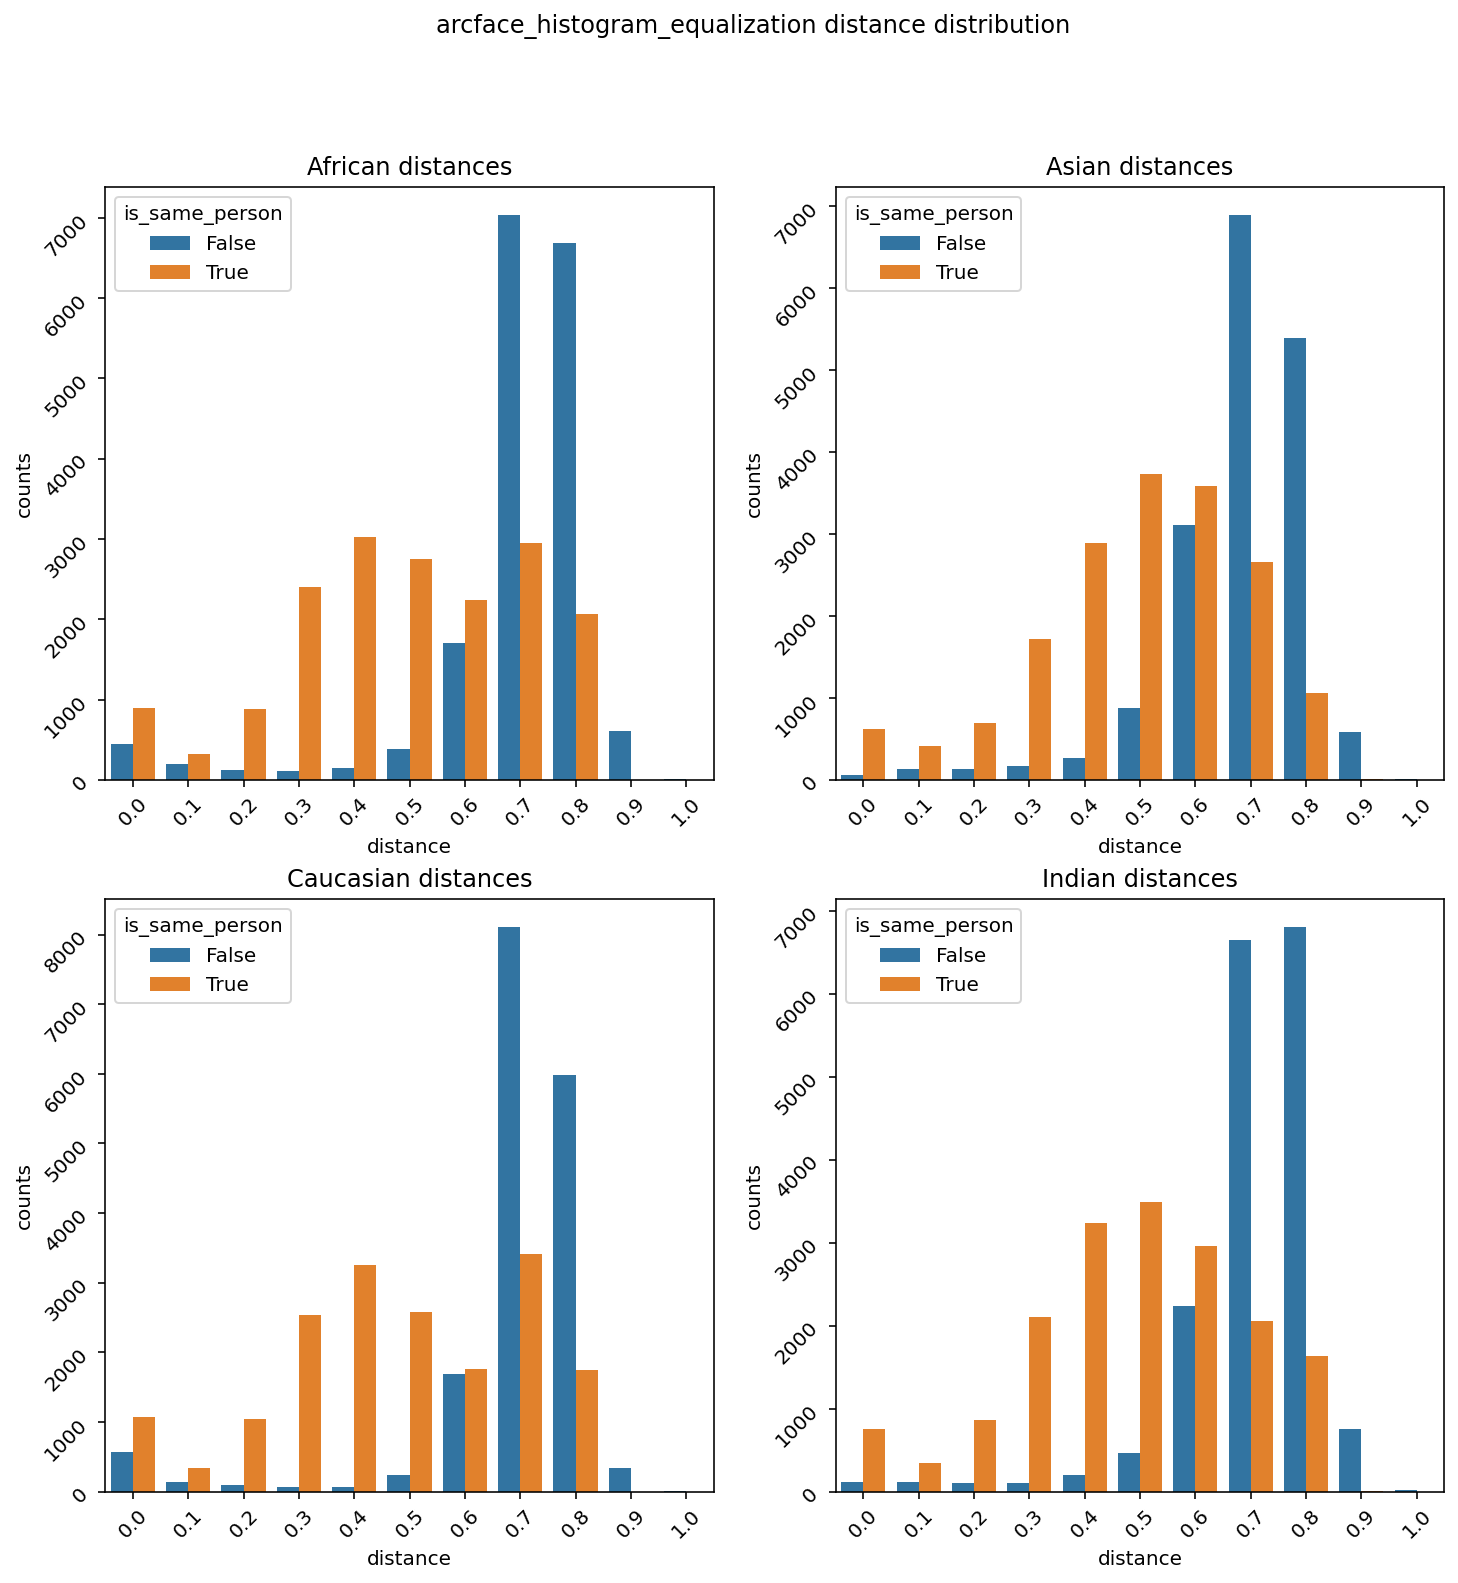

In [32]:
plot_score_distribution(arcface_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [33]:
print("Asian difference in mean:",calculate_distribution_difference(arcface_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(arcface_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(arcface_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(arcface_model,"Indian"))

Asian difference in mean: -0.2451471186609162
African difference in mean: -0.26751077204090823
Caucasian difference in mean: -0.2840452904788233
Indian difference in mean: -0.28577164212023354


**Results**:
* For all groups there are one or two spikes around 0.7 & 0.8
* Also the amount of non-pairs with 0 distance is significantly higher
* The distance of pairs is partly uniformly distributed (see African distances)
* Almost no discrimination power
* Generally big shift to the higher distances, might be due to geometric approach of ArcFace

## Paired significance tests

Usually a paired t-test would be the desired solution. However the normal distribution of the target variable is not fulfilled which is why we will go with a Wilcoxon-Signed-Rank-Test which is slightly less effective but has less assumptions.

The goal is to investigate if there are significant differences in the mean of the ethnic groups produced by a model. An unbiased model would present similar results. The two-sided test has the null hypothesis that the median of the differences is zero against the alternative that it is different from zero.

For independent sample we will use the Wilcoxon-RankSum-Test (NUll hypothesis = the observations come from the same population).

### General

The first step is to generate all possible combinations of comparisons

In [34]:
def perform_significance_test(model1, model2, ethnic, test_type = st.wilcoxon):
    data1 = pd.DataFrame()
    data2 = pd.DataFrame()
    for j in range(1,6):
        with open(f'results/{model1}/{ethnic}/result_dict{j}.pickle', "rb") as f:
                results = pickle.load(f)
        data_temp = results['data']
        data1 = data1.append(data_temp)
        
        with open(f'results/{model2}/{ethnic}/result_dict{j}.pickle', "rb") as f:
                results = pickle.load(f)
        data_temp = results['data']
        data2 = data2.append(data_temp)        

    return test_type(data1.distance, data2.distance)


In [35]:
ethnic_groups = ["Caucasian", "Asian", "African", "Indian"]

### FaceNet512

In [36]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance:",perform_significance_test("facenet", facenet_model, ethnic)[1])

Wilcoxon test on Caucasian performance: 5.258173401509038e-06
Wilcoxon test on Asian performance: 0.02014790492417271
Wilcoxon test on African performance: 5.700841164330862e-23
Wilcoxon test on Indian performance: 5.30382515918385e-07


**Results**:
* Testing all combinations lets us reject all null hypothesises

### VGG-Face

In [37]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance: ",perform_significance_test("vgg_face", vgg_face_model, ethnic)[1])

Wilcoxon test on Caucasian performance:  0.004351280045460799
Wilcoxon test on Asian performance:  3.265747903345019e-43
Wilcoxon test on African performance:  2.0126159378919773e-70
Wilcoxon test on Indian performance:  5.963346754656715e-11


**Results**:
* Testing all combinations lets us reject all null hypothesises

### ArcFace

In [38]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance: ",perform_significance_test("arcface", arcface_model, ethnic)[1])

Wilcoxon test on Caucasian performance:  0.015121480296842299
Wilcoxon test on Asian performance:  3.135466652924243e-15
Wilcoxon test on African performance:  0.00015980594313004046
Wilcoxon test on Indian performance:  2.0852601936304208e-11


**Results**:
* Testing all combinations lets us reject all null hypothesises

## Image description with Lime

Differnent models identify different areas in an image as important. Here we want to compare which areas are important to which model.

Ideally the ethic groups should be described similarly.

### General

In [39]:
asian_img_path ='data/race_per_7000/Asian/m.03cfpv1/000050_00@en.jpg'
african_img_path = 'data/race_per_7000/African/m.03v416/32-FaceId-0_align.jpg'
caucasian_img_path = 'data/race_per_7000/Caucasian/m.0356k8/26-FaceId-0_align.jpg'
indian_img_path = 'data/race_per_7000/Indian/m.0l8nmsx/000016_00@hi.jpg'

### FaceNet512

In [40]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(160,160), preprocessing = equalize_image)
african_img = load_image(path=african_img_path,shape=(160,160), preprocessing = equalize_image)
caucasian_img = load_image(path=caucasian_img_path,shape=(160,160), preprocessing = equalize_image)
indian_img = load_image(path=indian_img_path,shape=(160,160), preprocessing = equalize_image)

In [41]:
facenet512 = DeepFace.build_model("Facenet512")

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -0.6773068419579972
Prediction_local [2.11932536]
Right: 2.4458966
Intercept -0.17872270455672523
Prediction_local [2.47476101]
Right: 2.710238


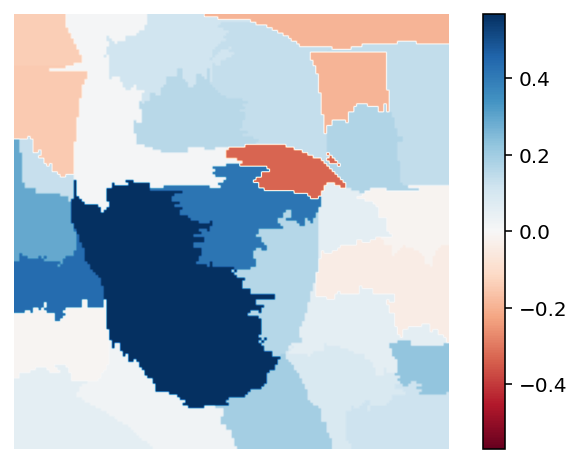

In [42]:
plot_face_heatmap(facenet512, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -1.6622667981831465
Prediction_local [2.08676866]
Right: 2.941608
Intercept -0.5690549417000106
Prediction_local [2.87041788]
Right: 3.1478786


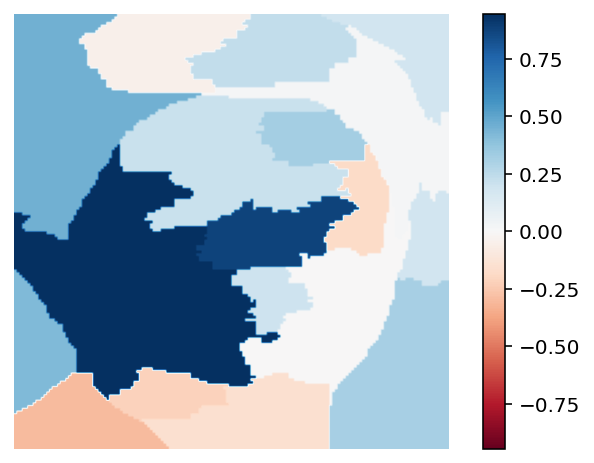

In [43]:
plot_face_heatmap(facenet512, asian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -3.289202839278857
Prediction_local [2.26567919]
Right: 3.251637
Intercept -3.5141065292901175
Prediction_local [2.18832545]
Right: 3.397406


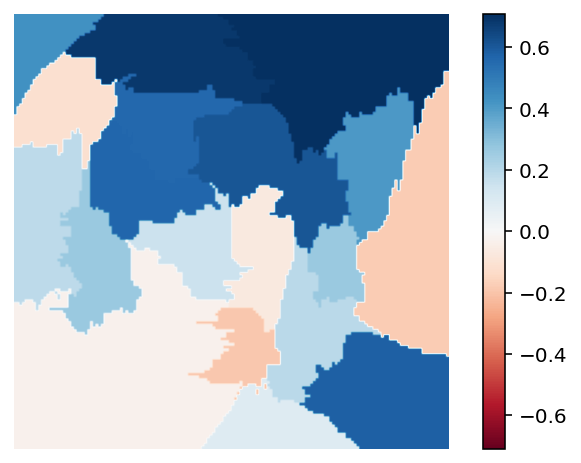

In [44]:
plot_face_heatmap(facenet512, caucasian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -1.5073019277492585
Prediction_local [1.31153704]
Right: 2.4041777
Intercept -0.38595278927573173
Prediction_local [2.32948405]
Right: 2.813751


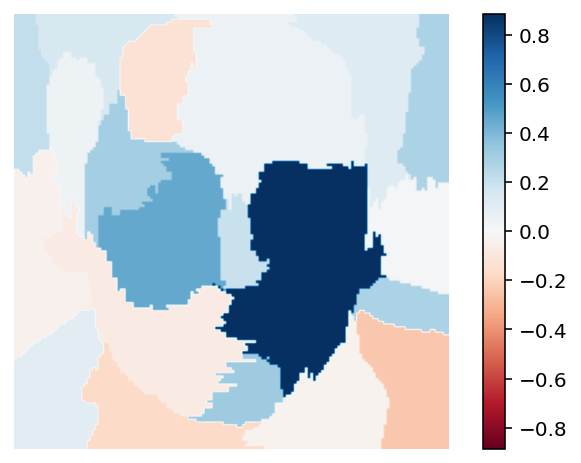

In [45]:
plot_face_heatmap(facenet512, indian_img)

### VGG-Face

In [46]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(224,224), preprocessing = equalize_image)
african_img = load_image(path=african_img_path,shape=(224,224), preprocessing = equalize_image)
caucasian_img = load_image(path=caucasian_img_path,shape=(224,224), preprocessing = equalize_image)
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = equalize_image)

In [47]:
vgg_face = DeepFace.build_model("VGG-Face")

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 0.03174786914742339
Prediction_local [0.05891698]
Right: 0.058556378
Intercept -0.044180628400411266
Prediction_local [0.06221028]
Right: 0.061647847


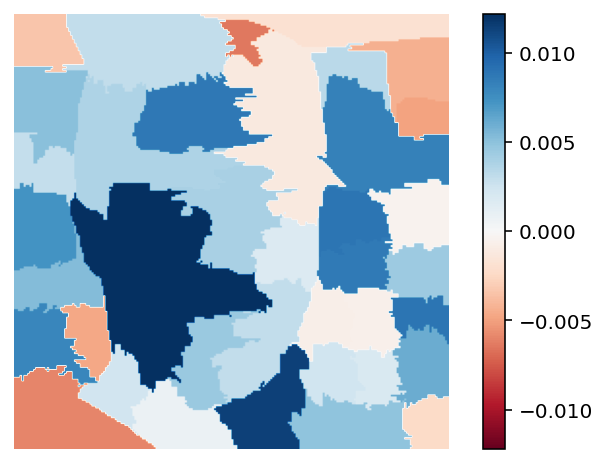

In [48]:
plot_face_heatmap(vgg_face, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 0.030104926711106896
Prediction_local [0.06383903]
Right: 0.058556378
Intercept -0.042590263931272576
Prediction_local [0.06513517]
Right: 0.061647847


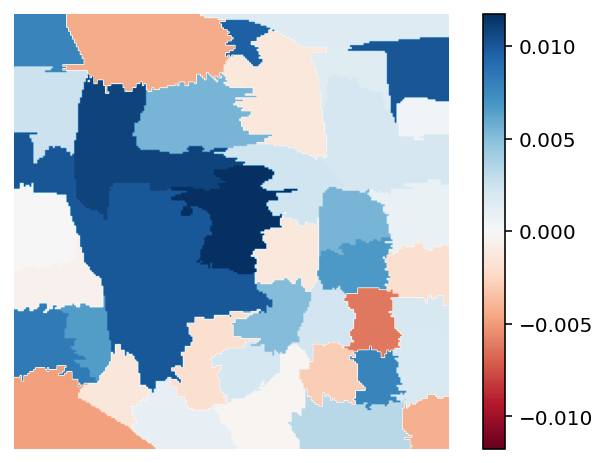

In [49]:
plot_face_heatmap(vgg_face, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -0.014466255384723632
Prediction_local [0.0580294]
Right: 0.06538921
Intercept 0.10135480940937185
Prediction_local [0.07002385]
Right: 0.066207096


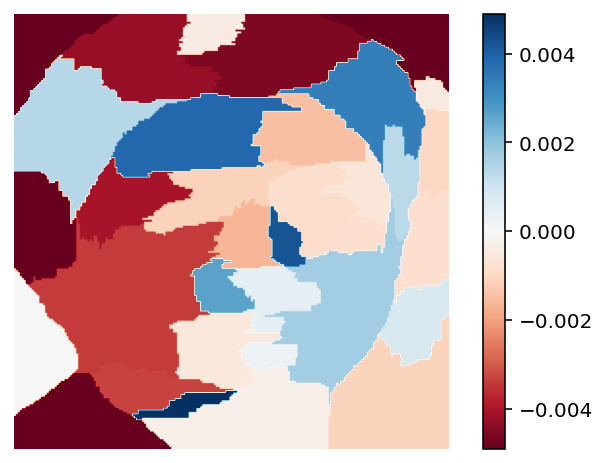

In [50]:
plot_face_heatmap(vgg_face, asian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -0.1073667229533349
Prediction_local [0.09979024]
Right: 0.109685406
Intercept -0.08255312687552889
Prediction_local [0.09253946]
Right: 0.11153498


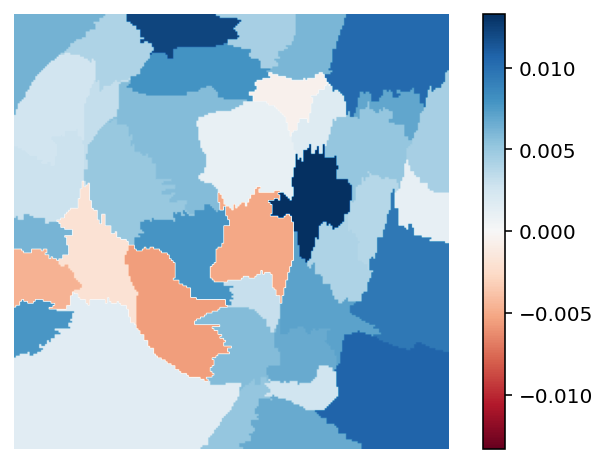

In [51]:
plot_face_heatmap(vgg_face, caucasian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 0.04692632754158845
Prediction_local [0.03875022]
Right: 0.037374463
Intercept -0.04418432311645446
Prediction_local [0.03562071]
Right: 0.04550067


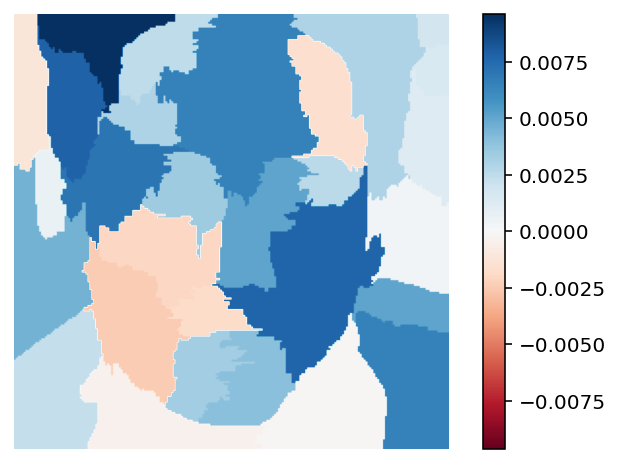

In [52]:
plot_face_heatmap(vgg_face, indian_img)

### ArcFace

In [53]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(112,112), preprocessing = equalize_image)
african_img = load_image(path=african_img_path,shape=(112,112), preprocessing = equalize_image)
caucasian_img = load_image(path=caucasian_img_path,shape=(112,112), preprocessing = equalize_image)
indian_img = load_image(path=indian_img_path,shape=(112,112), preprocessing = equalize_image)

In [54]:
arcface = DeepFace.build_model("ArcFace")

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 0.8205318088482795
Prediction_local [0.81976124]
Right: 0.27538815
Intercept 10.143297065291822
Prediction_local [3.29014869]
Right: 0.38241002


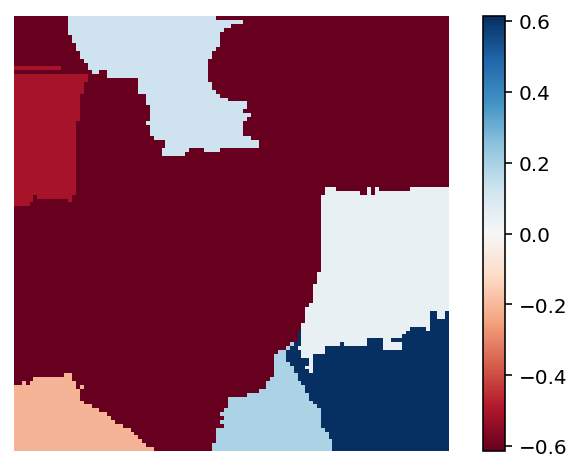

In [55]:
plot_face_heatmap(arcface, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 7.980505920037322
Prediction_local [0.7165659]
Right: 0.40566242
Intercept -3.4173710880641526
Prediction_local [0.83177065]
Right: 0.514159


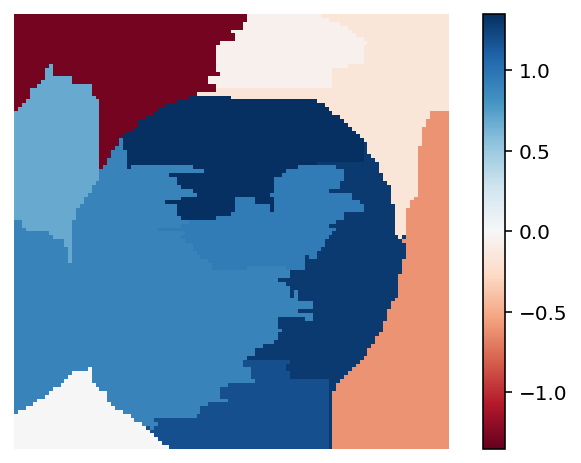

In [56]:
plot_face_heatmap(arcface, asian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -0.2584244369184864
Prediction_local [0.47640401]
Right: 0.3993446
Intercept -0.013439551599616018
Prediction_local [0.46698434]
Right: 0.3996247


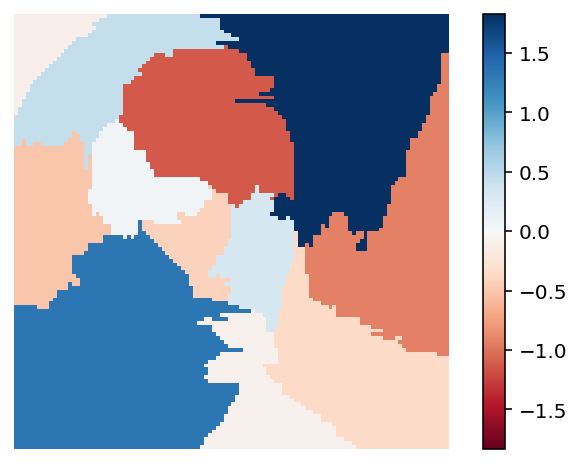

In [57]:
plot_face_heatmap(arcface, caucasian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 1.3961154159497493
Prediction_local [0.12747189]
Right: 0.42672178
Intercept 5.231964385066833
Prediction_local [1.22898601]
Right: 0.5497708


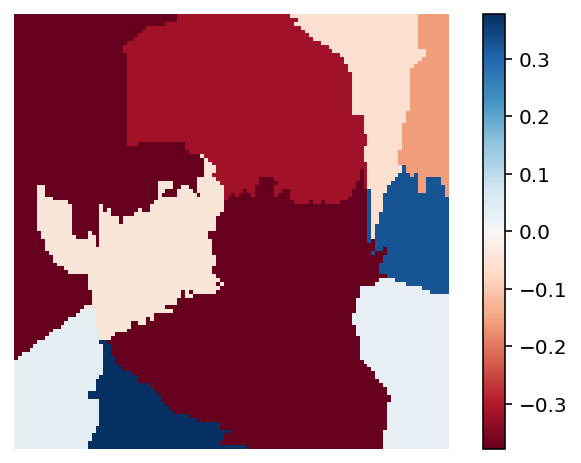

In [58]:
plot_face_heatmap(arcface, indian_img)

**Results**:
* Caucasian image has important forehead on all models
* ArcFace does not detect same face patterns for African as others